# PCA Lab

In this lab we will be practicing using PCA to analyze a genomic dataset


## The data

*Arabidopsis thaliana*. This data was downloaded from [The 1001 Genomes Project](https://1001genomes.org/data/GMI-MPI/releases/v3.1) and the file is called `1001genomes_snp-short-indel_only_ACGTN.vcf.gz` and is in the '/mnt/research/PLB812_FS24_S001/12_PCA' folder.

## Running PCA 

We will be using the software Plink to run PCA. Our first step will be loading the Plink module on the hpcc.

Run the following on command line

`$module purge` <br>
`$module load PLINK/2.00a3.7-gfbf-2023a`

Next, if your data is in a vcf file, you need to convert it to a plink format.  We will also want to filter these files to give us SNPs that are not in linkage disequilibrium with each other, and to remove rare sites or sites with a lot of missing data. You can look up each of the options in the following command to see how they work.

`$plink2 -vcf /mnt/research/PLB812_FS24_S001/12_PCA/1001genomes_snp-short-indel_only_ACGTN.vcf.gz --indep-pairwise 100 20 0.2 --geno 0.05 --max-alleles 2 --maf 0.05 --allow-extra-chr --make-bed --out /mnt/home/braunell/PLB812_homedir/1001_genomes_filtered`

If you were to do this another time and your data wass already in a plink format (file names end with **.bed** and **.bim** and **.fam** and have the same file prefix), you could run the following command:

`$plink2 -bfile [file-prefix] --indep-pairwise 100 20 0.2 --geno 0.05 --max-alleles 2 --maf 0.05 --allow-extra-chr --make-bed --out [file-prefix].filtered`

Once you have filtered your plink files of SNPs, it is time to run the PCA analysis!

`$plink2 -bfile /mnt/home/braunell/PLB812_homedir/arabidopsis --extract /mnt/home/braunell/PLB812_homedir/arabidopsis.prune.in --pca --allow-extra-chr --out /mnt/home/braunell/PLB812_homedir/arabidopsis_filtered-pca`
`$plink2 -bfile /mnt/home/braunell/PLB812_homedir/arabidopsis --extract /mnt/home/braunell/PLB812_homedir/arabidopsis.100.in --pca --allow-extra-chr --out /mnt/home/braunell/PLB812_homedir/arabidopsis_filtered-100-pca`
`$plink2 -bfile /mnt/home/braunell/PLB812_homedir/arabidopsis --extract /mnt/home/braunell/PLB812_homedir/arabidopsis.1000.in --pca --allow-extra-chr --out /mnt/home/braunell/PLB812_homedir/arabidopsis_filtered-1000-pca`
`$plink2 -bfile /mnt/home/braunell/PLB812_homedir/arabidopsis --extract /mnt/home/braunell/PLB812_homedir/arabidopsis.10000.in --pca --allow-extra-chr --out /mnt/home/braunell/PLB812_homedir/arabidopsis_filtered-10000-pca`

The above command did not work bc not enough memory so I navigated to a new dev node with ssh dev-intel18 and reran it with module purge then module load then ran the line
Note the `--extract` flag here directs you towards a list of sites that was generated in the previous filtered set. If you were to skip this, plink would try to run the PCA on all the sites, not just the sites that passed the filters. 

You can use **less** to look at the output files from this step, which will be `[file-prefix]-pca.eigenvec` and `[file-prefix]-pca.eigenval`.

Note I tried running the below slurm script but did not end up using it.

In [2]:
%%bash
# Create or overwrite the SLURM script file using a heredoc
cat > pca_slurm.sh <<EOF
#!/bin/bash --login
# Job name:
#SBATCH --job-name=pca_slurm_job

# Number of tasks (processes)
# SLURM defaults to 1 but we specify anyway
#SBATCH --ntasks=1

# Memory per node
# Specify "M" or "G" for MB and GB respectively
#SBATCH --mem=20M

# Wall time
# Format: "minutes", "hours:minutes:seconds", 
# "days-hours", or "days-hours:minutes"
#SBATCH --time=01:00:00

# Mail type
# e.g., which events trigger email notifications
#SBATCH --mail-type=ALL

# Mail address
#SBATCH --mail-user=braunell@msu.edu

# Standard output and error to file
# %x: job name, %j: job ID
#SBATCH --output=%x-%j.SLURM_pca_out

# Purge current modules and load those we require
module purge
module load PLINK/2.00a3.7-gfbf-2023a

# Run our job
cd /mnt/home/braunell/PLB812_homedir
plink2 -bfile /mnt/home/braunell/PLB812_homedir/arabidopsis --extract /mnt/home/braunell/PLB812_homedir/arabidopsis.prune.in --pca --allow-extra-chr --out /mnt/home/braunell/PLB812_homedir/arabidopsis_filtered-pca

# Print resource information
scontrol show job \$SLURM_JOB_ID
js -j \$SLURM_JOB_ID
EOF

## Subsampling SNPs

We talked in class about how the number of SNPs is important for making a PCA. In the lab we'll investigate this using the *A. thaliana* data.

We can efficiently subsample a smaller dataset by sampling from the [file-prefix].filtered.in site, and then only using these sites when we run the PCA. To subsample 100 sites, use the following bash command:

`shuf /mnt/home/braunell/PLB812_homedir/arabidopsis.prune.in | head -n 100 > /mnt/home/braunell/PLB812_homedir/arabidopsis.100.in`
`shuf /mnt/home/braunell/PLB812_homedir/arabidopsis.prune.in | head -n 1000 > /mnt/home/braunell/PLB812_homedir/arabidopsis.1000.in`
`shuf /mnt/home/braunell/PLB812_homedir/arabidopsis.prune.in | head -n 10000 > /mnt/home/braunell/PLB812_homedir/arabidopsis.10000.in`

Take a second to look at this command and think about what the different parts of it do (or ask a neighbor or Emily!).

Modify the command to take subsamples of 100, 1000, and 10,000 sites.

You can count the number of lines in your `[file-prefix].x.in` files using `wc -l [file]`. Use this to check that your subsampling worked correctly. Then, rerun your PCA on these subsamples.

## Making plots

You will need some extra information about the genotypes in your PCA.

This file is called `accessions.csv`.

There is a file called 'pca-plots.Rmd' in the class folder ('/mnt/research/PLB812_FS24_S001/12_PCA') that has code for making PCA plots. Please open it up in Rstudio, edit the paths for your own data, and make PCA plots for all the SNPs and then for PCAs made from each subset.

When you're done, put the PCA plots in this notebook.

## Questions
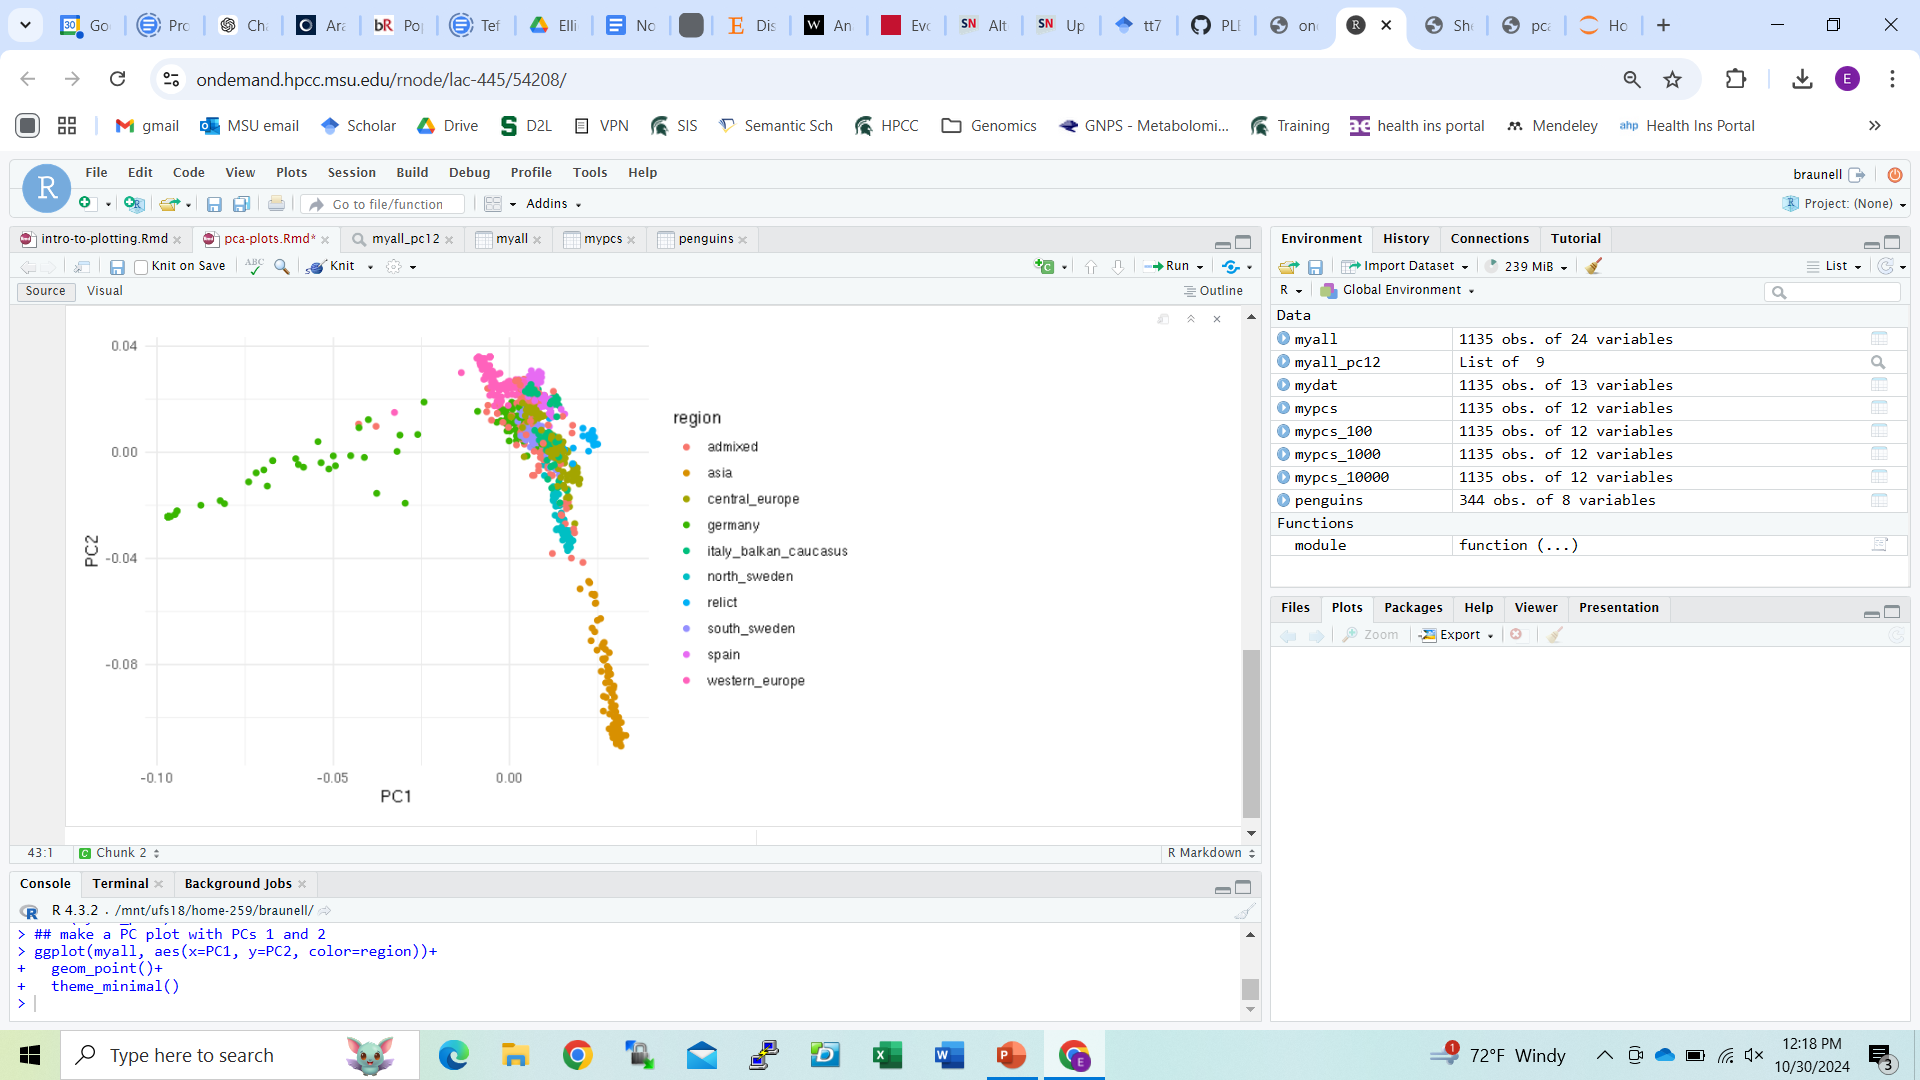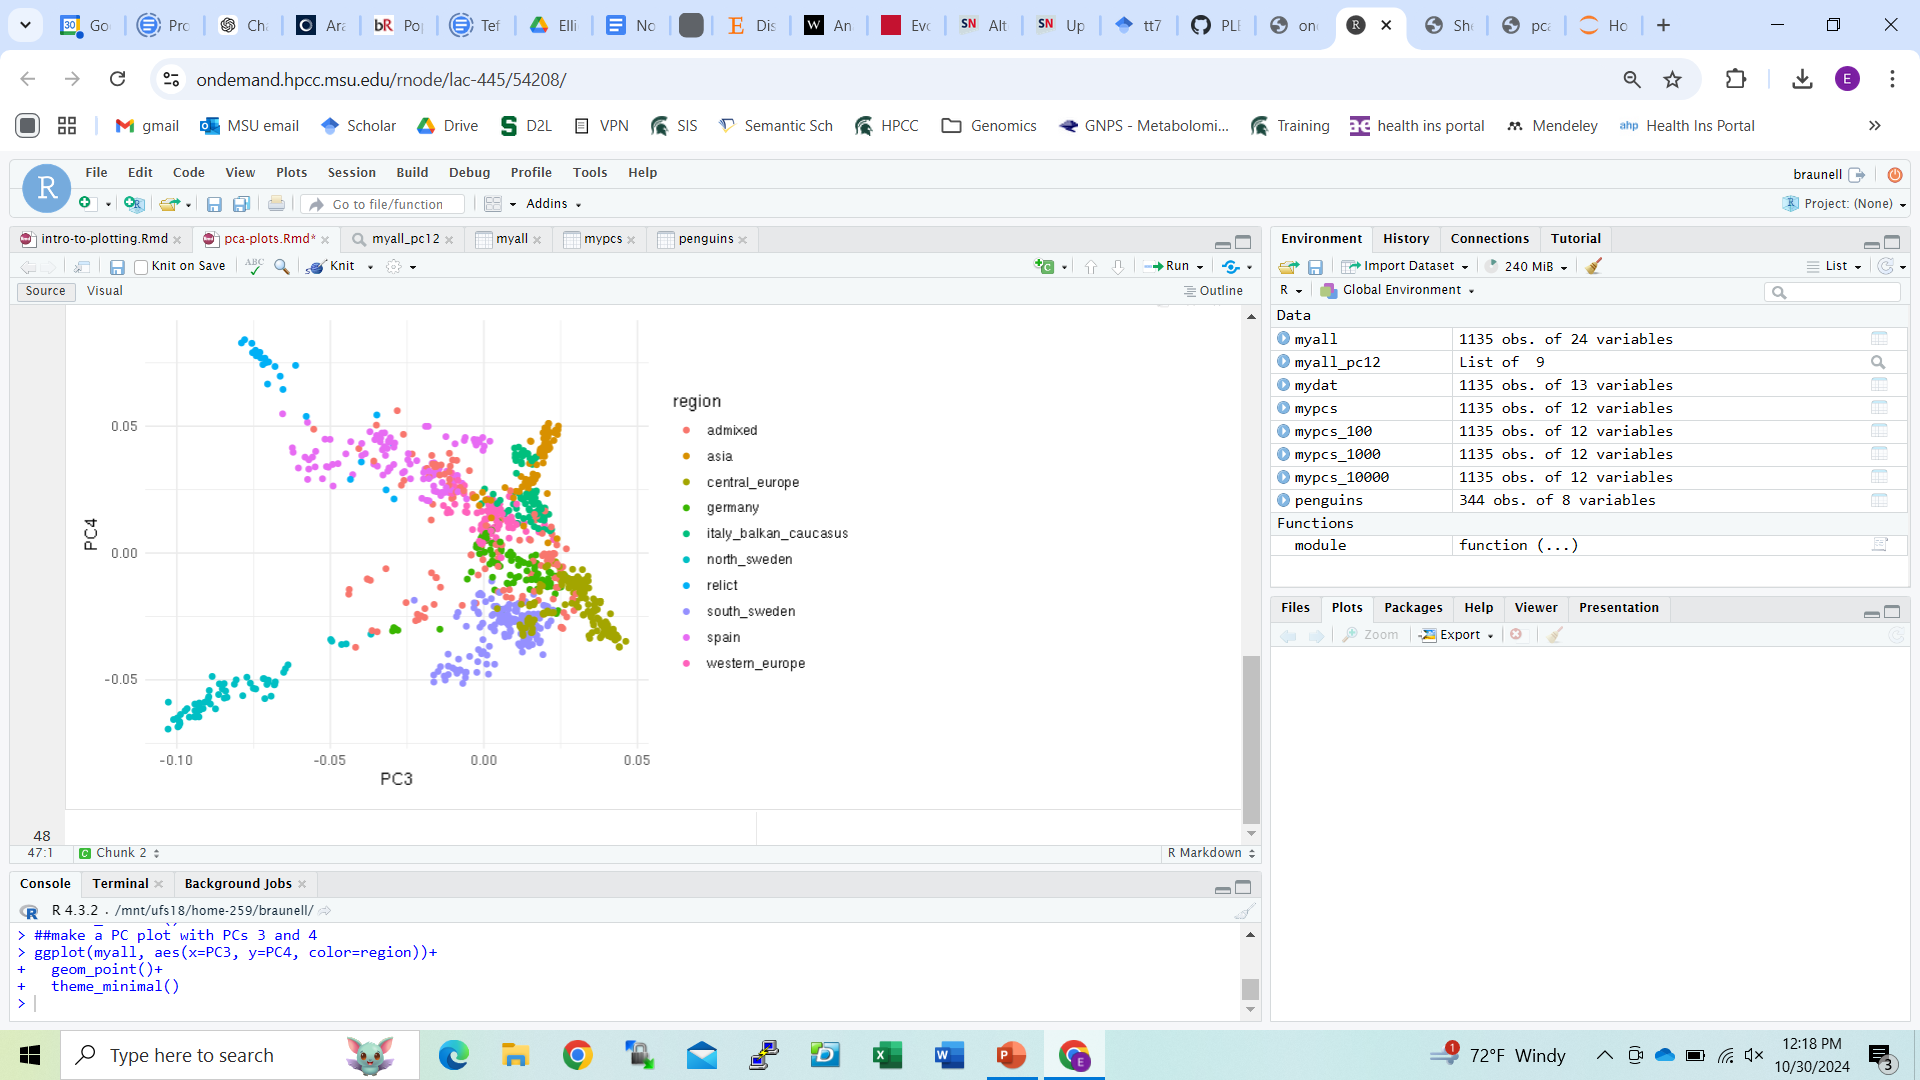
1. Based on the plot you've made, what are the major axes of variation in your diversity dataset? How do you know this?
   The major axes of variation appear to be PC1 (separates some of Germany), PC2 (separates Asia), PC3 (separates North Sweden), and PC4 (separates South Sweden and Spain)
3. How many sites were in the dataset of all SNPs that you used to calculate the PCA without subsampling? How did you find this out?
There appears to be 601 sites. This was found by running the following command: length(unique(mydat$V5))

4. How did changing the number of SNPs affect the PCA plots you made? How many SNPs would you recommend that another researcher use for Arabidopsis PCA?
   I saw much less separation by PCs with using less SNPs, I would therefore recommend using as many SNPs as possible for Arabidopsis PCA

## Other helpful stuff:

[The Documentation for Plink2](https://www.cog-genomics.org/plink/2.0/)

[A tutorial on PCA using Plink](https://www.zoology.ubc.ca/~schluter/R/Genomics.html#PCA_with_PLINK2)